<a href="https://colab.research.google.com/github/HungPham2002/mnist-classification-using-torch-and-keras-framework/blob/main/mnist_classification_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing the dataset

In [5]:
data_path = '/content/drive/MyDrive/Colab_Notebooks/Basic Pytorch/Image_Classification_Pytorch'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(data_path, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(data_path, train=False, transform=transform, download=True)

In [6]:
isinstance(train_dataset, torch.utils.data.Dataset)

True

In [7]:
len(train_dataset)

60000

In [42]:
len(test_dataset)

10000

In [9]:
batch_size_train = 64
batch_size_test = 1000

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=True)

In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [12]:
example_data.shape

torch.Size([1000, 1, 28, 28])

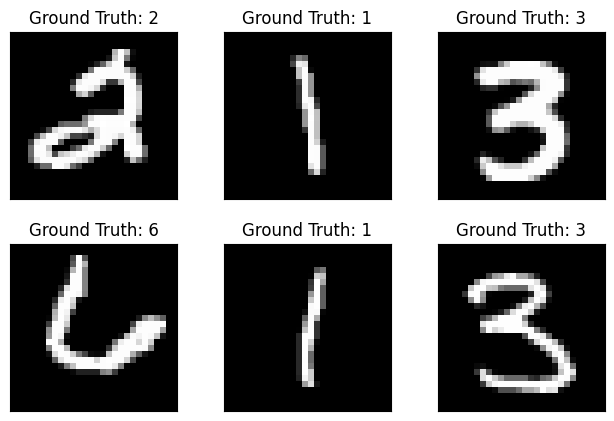

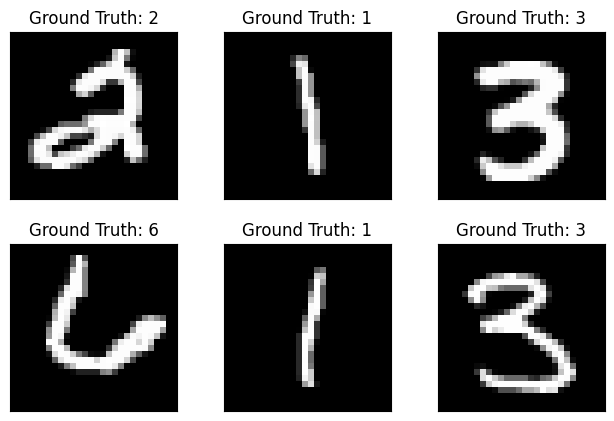

In [13]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Initialize network and optimizer

In [14]:
# model
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50,10)

  def forward(self,x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)


In [15]:
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [16]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

# Training the model

In [17]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [18]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/Basic Pytorch/Image_Classification_Pytorch/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/Basic Pytorch/Image_Classification_Pytorch/results/optimizer.pth')

In [47]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [20]:
test()

<ipython-input-14-e5bf5bc5cb6e>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3316, Accuracy: 1137/10000 (11%)



In [21]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.360446


<ipython-input-14-e5bf5bc5cb6e>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.364010
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.329987
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.249067
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.288059
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.218085
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.214215
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.111192
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.092593
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.989863
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.911151
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.659503
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.869479
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.660094
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.577335
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.550470
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.304469
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.408615
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.306857
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.171410
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.161339
Train Epoch: 1 [13440/60

In [63]:
test()

<ipython-input-14-e5bf5bc5cb6e>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0586, Accuracy: 9820/10000 (98%)



# Evaluate the model performance

Text(0, 0.5, 'negative log likelihood loss')

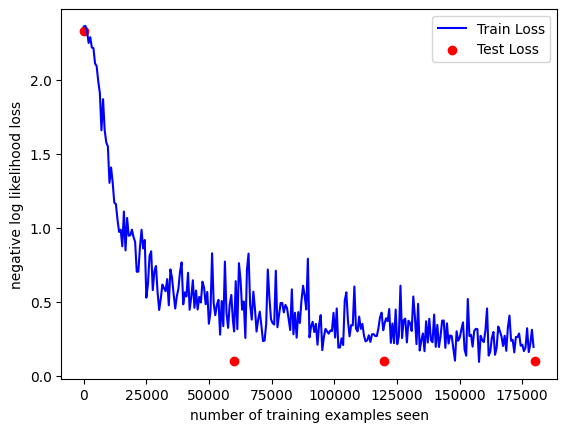

In [53]:
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


In [ ]:
with torch.no_grad():
  output = model(example_data)

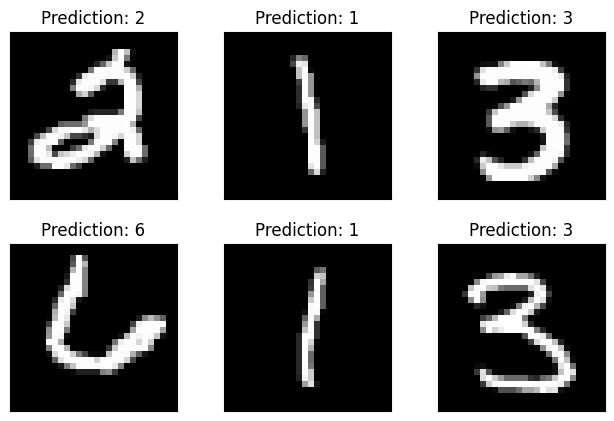

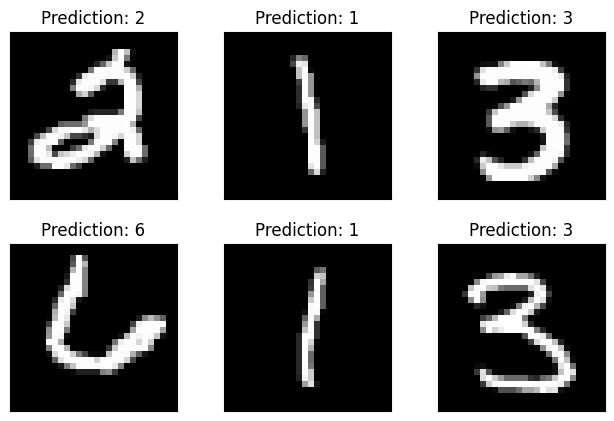

In [56]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

# Continued training from checkpoints

In [57]:
continued_network = Net()
continued_optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                                momentum=momentum)

In [58]:
network_state_dict = torch.load('/content/drive/MyDrive/Colab_Notebooks/Basic Pytorch/Image_Classification_Pytorch/results/model.pth')
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('/content/drive/MyDrive/Colab_Notebooks/Basic Pytorch/Image_Classification_Pytorch/results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [59]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

<ipython-input-14-e5bf5bc5cb6e>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.261792
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.274454
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.302220
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.312160
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.161405
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.185558
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.151217
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.122113
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.135832
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.184512
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.136049
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.209028
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.282582
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.634747
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.323479
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.279102
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.208233
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.359531
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.317275
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.390599
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0848, Accuracy: 9731/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.322689
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.233113
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.425403
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.349491
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.207980
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.230060
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.254407
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.211882
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.203710
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.184485
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.318933
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.200464
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.204525
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.212064
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.220554
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.418277
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.215217
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.431916
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.220421
Train Epoch: 5 [12160

In [67]:
print(len(test_counter))
print(len(test_losses))

9
9


Text(0, 0.5, 'negative log likelihood loss')

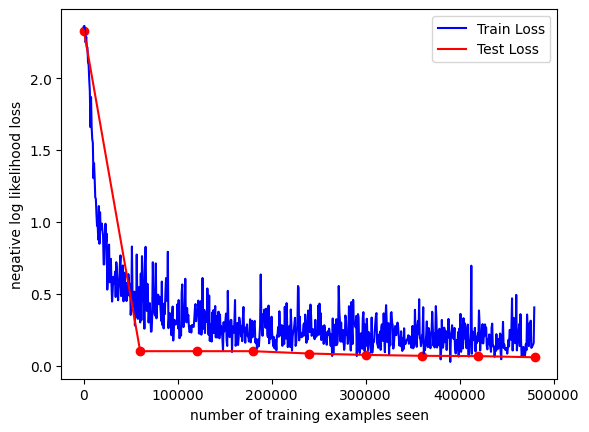

In [70]:
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')